In [14]:
# ライブラリ
from collections import deque
from matplotlib.animation import FuncAnimation
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import torch
import torch.nn as nn

In [ ]:
# 日本語フォント
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

### Buck Structure and Inference
バック構造と推論


In [16]:
class PANN(nn.Module):
    """
    汎用的な物理内包型アーキテクチャニューラルネットワーク（PANN）構造を定義する

    参考文献：
    1: 「物理内包型アーキテクチャリカレントニューラルネットワークを用いた電力変換器の時間的モデリング」
        論文DOI: 10.1109/TIE.2024.3352119

    2: 「データ軽量な物理インフォームドモデリングによるデュアルアクティブブリッジコンバータの変調最適化」
        論文DOI: 10.1109/TPEL.2024.3378184
    """

    def __init__(self, cell, **kwargs):
        super(PANN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, inputs, x):
        outputs = []
        _x = x[:, 0]  # stateの初期化
        for t in range(inputs.shape[1]):
            state_next = self.cell.forward(
                inputs[:, t, :], _x
            )  # 1タイムスタンプ分を推論
            _x = state_next  # 予測された状態（state_next）を現在の状態として更新
            outputs.append(_x)  # 予測された状態をoutputsに追加
        return torch.stack(outputs, dim=1)


class EulerCell_Buck(nn.Module):
    """
    従来型のBuckコンバータに対するPANNの陽的オイラーリカレントセルを定義
    """

    def __init__(self, dt, L, Co, Ro, **kwargs):
        super(EulerCell_Buck, self).__init__(**kwargs)
        self.dt = dt
        self.L = nn.Parameter(torch.Tensor([L]))
        self.Co = nn.Parameter(torch.Tensor([Co]))
        self.Ro = nn.Parameter(torch.Tensor([Ro]))

    def forward(self, inputs, states):
        # 陽的オイラー法
        # inputs : s_pri*Vin を表す
        # states : iL, vo を表す
        vo = states[:, 1]
        va = inputs[:, 0]  # 端子電圧
        idx = (inputs[:, 0] == 0) & (states[:, 0] <= 0)  # 離散導通モード（DCM）を評価
        va[idx] = vo[idx]
        iL_next = states[:, 0] + self.dt / self.L * (va - vo)  # iLの物理モデル
        iL_next = torch.relu(iL_next)  # DCMを考慮するためにtorch.reluを適用
        vC_next = states[:, 1] + self.dt / self.Co * (
            states[:, 0] - vo / self.Ro
        )  # vCの物理モデル
        return torch.stack((iL_next, vC_next), dim=1)


In [17]:
# 回路パラメータおよびネットワーク変数を定義する
L, Co, Ro = 50e-6, 1000e-6, 3
Ts = 1 / 20e3
Tslen = 100
dt = Ts / Tslen

buck_Euler_cell = torch.jit.script(
    EulerCell_Buck(dt, L, Co, Ro)
)  # DAB（Dual Active Bridge）用のオイラーセルを定義する
pann_buck = torch.jit.script(
    PANN(buck_Euler_cell)
)  # DAB（Dual Active Bridge）用のPANN（物理内包型ニューラルネットワーク）を定義する
print(pann_buck)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_Buck)
)


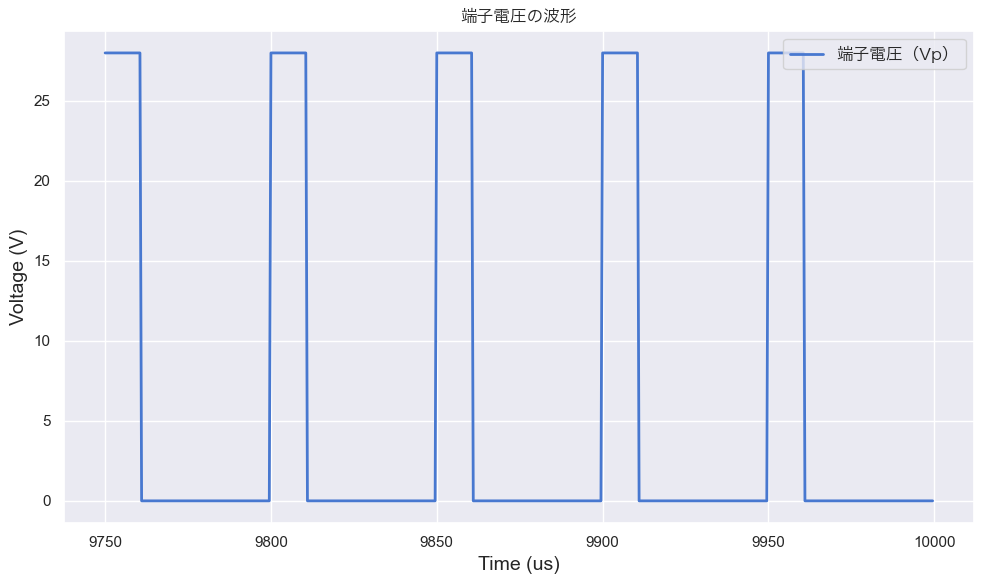

In [21]:
def duty_cycle_mod(D0, Vin, dt, Tsim, Ts):
    """
    バックコンバータの変調戦略
    """
    t = np.linspace(0, Ts, round(Ts / dt), endpoint=False)
    s_pri = deque(signal.square(2 * np.pi / Ts * t, D0))
    vp = np.array(s_pri).clip(0, 1) * Vin
    vp = np.tile(vp, (round(Tsim / Ts),))
    return vp


Vin, Vref = 28, 6
D0 = Vref / Vin
Tsim = 200 * Ts  # スイッチング周期の10倍を考慮したシミュレーション時間
# 1組の変調パラメータに基づいて端子電圧波形 vp を生成する
vp = duty_cycle_mod(D0, Vin, dt, Tsim, Ts)
t = np.arange(0, len(vp) * dt, dt)


# ============================
# 交流電圧波形 vp をプロットする
# ============================
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

plt.plot(
    t[-5 * Tslen :] * 1e6,
    vp[-5 * Tslen :],
    label="端子電圧（Vp）",
    color=sns.color_palette("muted")[0],
    linestyle="-",
    linewidth=2,
)
plt.legend(loc="upper right", fontsize=12, prop=font_prop)

plt.title("端子電圧の波形", fontsize=18, weight="bold", fontproperties=font_prop)
plt.xlabel("Time (us)", fontsize=14)
plt.ylabel("Voltage (V)", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# NumPyで入力テンソルを構築する
inputs = vp[None, :, None]
# inputs の形状は (バッチサイズ × シーケンス長 × 入力次元) でなければならない
print(inputs.shape, type(inputs))
# torch の FloatTensor に変換する
inputs = torch.FloatTensor(inputs)
print(inputs.shape, type(inputs))


# 状態変数を初期化する
state_dim = 2
state0 = torch.zeros((inputs.shape[0], 1, state_dim))
# PANNを用いて状態変数iLを推論する
pann_buck.eval()
with torch.no_grad():
    # 学習ではないため、計算グラフは保持しない
    states = pann_buck(inputs, state0)
print(states.shape, type(states))

(200,)
(1, 200, 1) <class 'numpy.ndarray'>
torch.Size([1, 200, 1]) <class 'torch.Tensor'>
torch.Size([1, 200, 2]) <class 'torch.Tensor'>


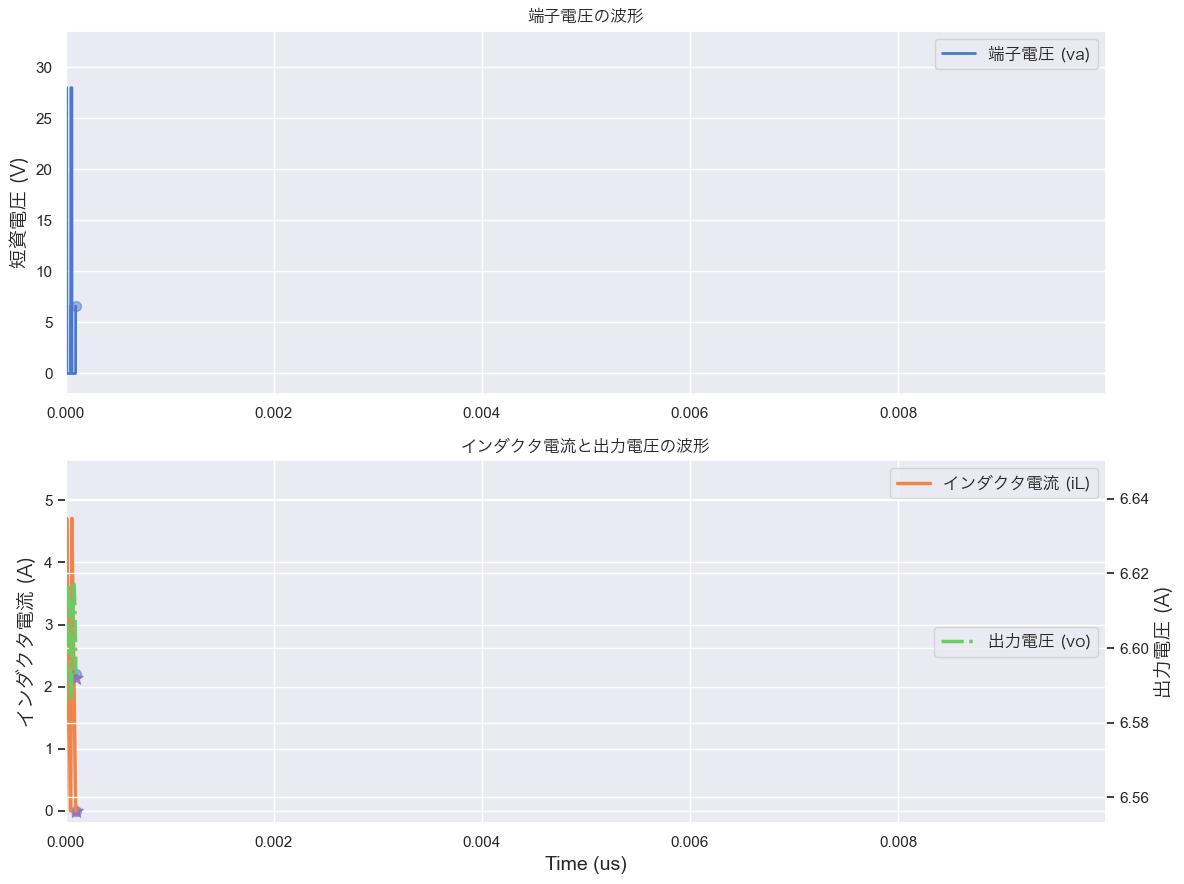

In [25]:
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]
# vpおよびvsの例となるデータ
# inputs: サイズは (シーケンス長 × 入力次元)
# states: サイズは (シーケンス長 × 状態次元)
sns.set_theme(style="darkgrid")

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
vp, iL, vo = inputs[:, 0], states[:, 0], states[:, 1]
# 図とサブプロットを作成（2つのサブプロット：1つは vp 用、もう1つは vs 用）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
ax22 = ax2.twinx()  # 同じx軸を共有する2つ目の座標軸（Axes）を作成する
# 両方のプロットに対して表示範囲（リミット）を設定する
ax1.set_xlim(t.min(), t.max())
ax1.set_ylim(-2, inputs.max() * 1.2)
ax2.set_xlim(t.min(), t.max())
ax2.set_ylim(-0.2, states[:, 0].max() * 1.2)
ax22.set_ylim(states[:, 1].min() * 0.995, states[:, 1].max() * 1.005)

ax1.set_title("端子電圧の波形", fontsize=15, weight="bold", fontproperties=font_prop)
ax2.set_title(
    "インダクタ電流と出力電圧の波形",
    fontsize=15,
    weight="bold",
    fontproperties=font_prop,
)

ax1.set_ylabel("短資電圧 (V)", fontsize=14, fontproperties=font_prop)
ax2.set_xlabel("Time (us)", fontsize=14)
ax2.set_ylabel("インダクタ電流 (A)", fontsize=14, fontproperties=font_prop)
ax22.set_ylabel("出力電圧 (A)", fontsize=14, fontproperties=font_prop)

# 両方のプロット用に空のライン（lineオブジェクト）を初期化する
(line1_1,) = ax1.plot(
    [],
    [],
    lw=2,
    label="端子電圧 (va)",
    color=sns.color_palette("muted")[0],
    linestyle="-",
)
(line2_1,) = ax2.plot(
    [],
    [],
    lw=2.5,
    label="インダクタ電流 (iL)",
    color=sns.color_palette("muted")[1],
    linestyle="-",
)
(line2_2,) = ax22.plot(
    [],
    [],
    lw=2.5,
    label="出力電圧 (vo)",
    color=sns.color_palette("muted")[2],
    linestyle="-.",
)
dot1_1 = ax1.scatter(
    [],
    [],
    edgecolor=sns.color_palette("muted")[0],
    alpha=0.5,
    s=50,
    color=sns.color_palette("muted")[0],
    marker="o",
)
dot2_1 = ax2.scatter(
    [],
    [],
    edgecolor=sns.color_palette("muted")[0],
    alpha=0.5,
    s=50,
    color=sns.color_palette("muted")[0],
    marker="o",
)
dot2_2 = ax22.scatter(
    [],
    [],
    edgecolor=sns.color_palette("muted")[0],
    alpha=0.5,
    s=50,
    color=sns.color_palette("muted")[0],
    marker="o",
)
dot2_3 = ax2.scatter(
    [],
    [],
    edgecolor=sns.color_palette("muted")[4],
    alpha=0.8,
    s=100,
    color=sns.color_palette("muted")[4],
    marker="*",
)
dot2_4 = ax22.scatter(
    [],
    [],
    edgecolor=sns.color_palette("muted")[4],
    alpha=0.8,
    s=100,
    color=sns.color_palette("muted")[4],
    marker="*",
)

ax1.grid(True)
ax2.grid(True)
ax1.legend(loc="upper right", fontsize=12, prop=font_prop)
ax2.legend(loc="upper right", fontsize=12, prop=font_prop)
ax22.legend(loc="center right", fontsize=12, prop=font_prop)


# アニメーションの初期化
def init():
    line1_1.set_data([], [])
    line2_1.set_data([], [])
    line2_2.set_data([], [])
    # サブプロット1用に空の散布図（scatter）を初期化する
    dot1_1.set_offsets(np.empty((0, 2)))
    dot2_1.set_offsets(np.empty((0, 2)))
    dot2_2.set_offsets(np.empty((0, 2)))
    dot2_3.set_offsets(np.empty((0, 2)))
    dot2_4.set_offsets(np.empty((0, 2)))
    return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4


# プロットを更新する
def update(frame):
    line1_1.set_data(t[: frame + 1], vp[: frame + 1])  # vp プロットを徐々に更新
    line2_1.set_data(t[: frame + 1], iL[: frame + 1])  # iL プロットを徐々に更新
    line2_2.set_data(t[: frame + 1], vo[: frame + 1])  # vo プロットを徐々に更新
    dot1_1.set_offsets(np.c_[t[frame + 1], vp[frame + 1]])
    dot2_1.set_offsets(np.c_[t[frame], iL[frame]])
    dot2_2.set_offsets(np.c_[t[frame], vo[frame]])
    dot2_3.set_offsets(np.c_[t[frame + 1], iL[frame + 1]])
    dot2_4.set_offsets(np.c_[t[frame + 1], vo[frame + 1]])

    return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4


# アニメーションを作成する
ani = FuncAnimation(
    fig, update, frames=inputs.shape[0] - 1, init_func=init, blit=False, interval=5
)

# GIFファイルとして保存する
ani.save("Buck-inference.gif", writer="pillow")

# プロットを表示する
plt.tight_layout()
plt.show()